# Decision tree leaf sizes: complexity vs regularization
Hypothesis: In a decision tree,
1. the number of leaves corresponds to the function complexity
2. the more small leaves there are, the less regularization there is.

In [120]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import zero_one_loss
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import sys
sys.path.append('../functions/')
from dataset import generate_gaussian_parity

In [158]:
def evalues_from_regions(L, full=False):
    """
    Efficiently computes eigenvalues of the representation matrix/Kernel (Gram)
    matrix when it comes from assignments of samples to regions.

    Parameters
    ----------
    L : list or numpy.ndarray, length (n_samples)
        The identification of which sample occurs in which region. Can be
        a list of internal representation matrices or raw bitstring ids.
        
    full : boolean, default=False
        If True, returns the correct number of zero eigenvalues too.

    Returns
    -------
    evalues : numpy.ndarray, shape (n_samples,)
        Eigenvalues
    """
    evalues = np.zeros(len(L))
    _, region_sizes = np.unique(L, return_counts=True, axis=0)
    region_sizes = np.sort(region_sizes)[::-1] # sort in decreasing order
    if full:
        evalues[:len(region_sizes)] = region_sizes
        return evalues
    else:
        return region_sizes
    
def tree2complexity(tree, X):
    return dt.get_n_leaves() / X.shape[0]

def tree2reg(tree, X, p=2):
    dist = evalues_from_regions(dt.apply(X)) / X.shape[0]
    # dist -= np.ones(dist.shape[0]) / dist.shape[0]
    return 1 / np.sum(np.abs(dist)**p)

## Data

In [181]:
X_train, y_train = generate_gaussian_parity(n=1000, angle_params=0, acorn=1234)
X_test, y_test = generate_gaussian_parity(n=10000, angle_params=0, acorn=66)

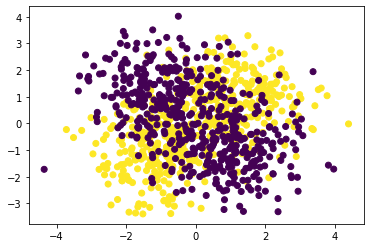

In [182]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
plt.show()

## Gridsearch paramters

In [183]:
complexities = []
regularizations = []
test_error = []
train_error = []

max_leaves = np.power(1.5, np.arange(1, 15)).astype(int) + 1 #np.power(2, np.arange(1, 10))
min_samples_leaf = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] # np.power(1.5, np.arange(1, 15)).astype(int)
min_samples_split = np.power(1.5, np.arange(1, 15)).astype(int) + 1

for rep in range(1):
    for ml in max_leaves:
        for ms in min_samples_split:#min_samples_leaf:
            dt = DecisionTreeClassifier(
                # splitter = 'random',
                max_leaf_nodes = ml,
                min_samples_split = ms,
                # min_samples_leaf = ms,
            ).fit(X_train, y_train)

            complexities.append(tree2complexity(dt, X_train))
            regularizations.append(tree2reg(dt, X_train, p=2))
            train_error.append(zero_one_loss(dt.predict(X_train), y_train))
            test_error.append(zero_one_loss(dt.predict(X_test), y_test))

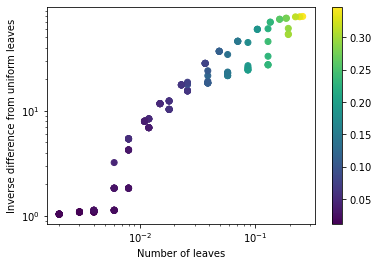

In [184]:
plt.scatter(
    complexities,
    regularizations,
    c=(np.asarray(test_error) - np.asarray(train_error)))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of leaves')
plt.ylabel('Inverse difference from uniform leaves')
plt.colorbar()
plt.show()

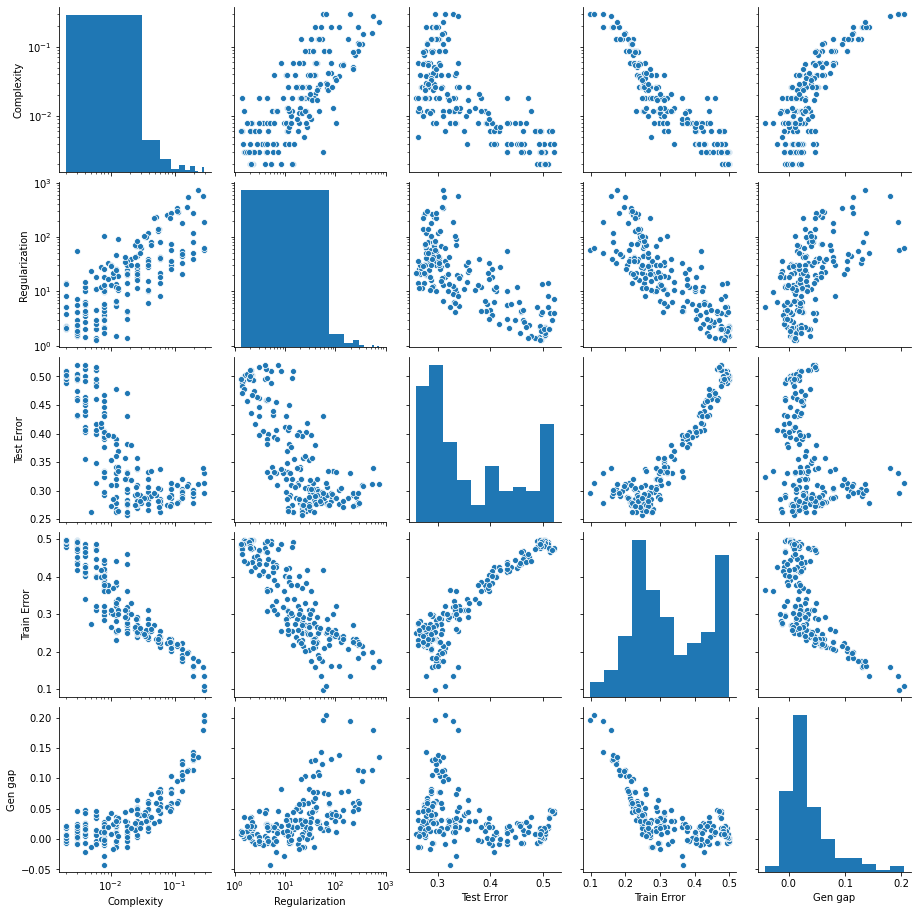

In [145]:
g = sns.pairplot(
    pd.DataFrame({
        'Complexity': complexities,
        'Regularization': regularizations,
        'Test Error': test_error,
        'Train Error': train_error,
        'Gen gap': np.asarray(test_error) - np.asarray(train_error)
    }),
    # vars = ['Complexity', 'Regularization', 'Test Error', 'Train Error'],
    # hue = 'Gen gap',
)
g.axes[0, 0].set_xscale('log')
g.axes[0, 0].set_yscale('log')
g.axes[0, 1].set_xscale('log')
g.axes[1, 0].set_yscale('log')

# g.set(xscale="log", yscale="log")
plt.show()

## Randomize over trees, same data

In [146]:
X_train, y_train = generate_gaussian_parity(n=1000, angle_params=0, acorn=1234)
X_test, y_test = generate_gaussian_parity(n=1000, angle_params=0, acorn=66)

In [150]:
complexities = []
regularizations = []
test_error = []
train_error = []

for _ in range(100):
    X_train, y_train = generate_gaussian_parity(n=100, angle_params=0, acorn=1234)
    X_test, y_test = generate_gaussian_parity(n=10000, angle_params=0, acorn=66)

    dt = DecisionTreeClassifier(
        splitter = 'random',
        max_leaf_nodes = None,
        min_samples_split = 2,
    ).fit(X_train, y_train)

    complexities.append(tree2complexity(dt, X_train))
    regularizations.append(tree2reg(dt, X_train, p=2))
    train_error.append(zero_one_loss(dt.predict(X_train), y_train))
    test_error.append(zero_one_loss(dt.predict(X_test), y_test))

# max_leaves = np.power(1.5, np.arange(1, 15)).astype(int) + 1#np.power(2, np.arange(1, 10))
# min_samples_leaf = np.power(1.5, np.arange(1, 15)).astype(int)
# min_samples_split = np.power(1.5, np.arange(1, 15)).astype(int) + 1

# for ml in max_leaves:
#     for ms in min_samples_split:#min_samples_leaf:
#         dt = DecisionTreeClassifier(
#             splitter = 'random',
#             max_leaf_nodes = None,
#             min_samples_split = ms,
#             # min_samples_leaf = ms,
#         ).fit(X_train, y_train)
        
#         complexities.append(tree2complexity(dt, X_train))
#         regularizations.append(tree2reg(dt, X_train, p=2))
#         train_error.append(zero_one_loss(dt.predict(X_train), y_train))
#         test_error.append(zero_one_loss(dt.predict(X_test), y_test))

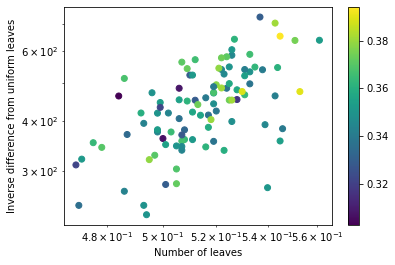

In [151]:
plt.scatter(
    complexities,
    regularizations,
    c=(np.asarray(test_error) - np.asarray(train_error)))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of leaves')
plt.ylabel('Inverse difference from uniform leaves')
plt.colorbar()
plt.show()